In [125]:
from email import policy

from HW2 import model
!pip install torch numpy gymnasium scipy tqdm SciencePlots


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import gymnasium
import scienceplots

from scipy import stats
from typing import List, Tuple
from gymnasium import Env, wrappers
from dataclasses import dataclass
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

plt.style.use('science')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if torch.mps.is_available():
        torch.mps.manual_seed(seed)

seed_everything(42)

Utils methods

In [78]:
def select_action(state: np.ndarray, policy: nn.Module, sample=True, device='mps') -> (int, torch.Tensor, torch.Tensor):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs, _ = policy(state)
    probs = probs.to(device)
    m = Categorical(probs=probs)
    if sample:
        action = m.sample()
    else:
        action = probs.argmax(dim=1)
    return action.item(), m.log_prob(action), probs.squeeze(0)

#### Vanilla Policy Gradient + Baseline

In [8]:
@dataclass
class ReinforceConfig:
    episodes: int
    discount_factor: float
    optimizer: optim.Optimizer
    model_name: str
    vf_optimizer: optim.Optimizer = None
    entropy_regularization: float = 0.0
    save_path: str = './models'
    validation_episodes: int = 100
    validate_every_th_episode: int = 20
    episode_steps_truncating: int = 600
    device: str = "mps"

In [72]:
# Policy

class PolicyNetwork(nn.Module):
    def __init__(self,state_dim:int=4, hidden_state_dim:int=64, action_space:int=2):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_state_dim)
        self.fc2 = nn.Linear(hidden_state_dim, action_space)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1), x


Я намеренно продублировал код в каждом алгоритме, чтобы легче было воспринимать ноутбук при проверке...

##### Параметры экспериментов

*Параметры обучения*

Шаг обучения `lr`=1e-3, количество успешных шагов для завершения эпизода `episode_steps_truncating`=600. Количество эпизодов `episodes`=1000, весовые коэффициенты энтропии `entropy_regularization`=[0.0, 0.001, 0.01, 0.1], коэффициент дисконтирования `discount_factor`=0.99. Для каждого эпизода устанавливаем `seed`=[1, `episodes`]. Каждый шаг семплируем из распределения вероятностей, выдаваемого политикой.

*Валидация модели*

Контролируем обучение на `validation_episodes`=20 эпизодах, для каждого эпизода устанавливаем `seed`=[`episodes` + 100, `validation_episodes`], действие выбираем на основе максимальной вероятности `prob.argmax()` (то есть не семплируем)

##### Average Reward Baseline

In [ ]:
def evaluate(environment: Env, policy: PolicyNetwork, eval_seeds: List[int]):
    policy.eval()
    with torch.no_grad():
        for seed in eval_seeds:
            state, _ = environment.reset(seed=seed)



In [ ]:
def fun(*args):
    return args

In [ ]:
def train_reinforce_with_ar_baseline(environment: Env, policy: nn.Module, config: ReinforceConfig):

    policy = policy.to(config.device)

    episodes_reward = [] # Суммарная награда за каждый тренировочный эпизод
    validation_rewards: List[List[float]] = [] # Списки наград за каждый валидационный эпизод для отслеживания дисперсии между эпизодами
    validation_mean_rewards: List[float] = [] # Средняя награда за все валидационные эпизоды в рамках одного тренировочного эпизода

    best_validation_rewards = [0.0] * config.validation_episodes

    train_seed = 1 # Будем менять в каждом эпизоде

    for episode in tqdm(range(config.episodes)):
        policy.train()
        state, _ = environment.reset(seed=train_seed)

        log_probs = []
        probs     = []
        rewards   = []

        step = 0
        while True:

            action, log_prob, prob = select_action(state, policy, device=config.device)
            log_probs.append(log_prob)
            probs.append(prob)

            state, reward, terminate, truncated, _ = environment.step(action)
            rewards.append(reward)

            if terminate:
                break
            if step >= config.episode_steps_truncating:
                break
            step += 1

        # Вычисляем дисконтированные награды для всех временных шагов
        discounted_rewards = []
        R_t = 0
        for r in reversed(rewards):
            R_t = float(r) + config.discount_factor * R_t
            discounted_rewards.insert(0, R_t)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32).to(config.device)

        # Учет средней награды
        average_reward = torch.tensor(rewards).mean()
        advantage = discounted_rewards - average_reward

        log_probs = torch.stack(log_probs, dim=-1).squeeze(0)
        policy_loss = (-log_probs * advantage).mean()

        # Энтропийный регуляризатор
        if config.entropy_regularization != 0.0:
            probs = torch.stack(probs, dim=0)
            entropy = -torch.sum(probs * torch.log(probs), dim=1)
            policy_loss += config.entropy_regularization * entropy.mean()

        # Оптимизация
        config.optimizer.zero_grad()
        policy_loss.backward()
        config.optimizer.step()

        # Валидация
        if episode % config.validate_every_th_episode == 0:
            policy.eval()
            with torch.no_grad():
                validation_seed = config.episodes + 100
                v = []
                for val_episode in range(config.validation_episodes):
                    state, _ = environment.reset(seed=validation_seed)
                    val_episode_reward = []
                    step = 0
                    while True:
                        action, log_prob, probs = select_action(state, policy, sample=False, device=config.device)
                        state, reward, terminate, truncated, _ = environment.step(action)
                        if terminate:
                            break
                        if step >= config.episode_steps_truncating:
                            break
                        step += 1
                        val_episode_reward.append(reward)
                    v.append(sum(val_episode_reward))
                    validation_seed += 1

                validation_rewards.append(v)
                validation_mean = np.array(v).mean()
                validation_std = np.array(v).std()

                if len(best_validation_rewards) == 0 or validation_mean > np.mean(best_validation_rewards):
                    t_statistic, p_value = stats.ttest_ind(v, best_validation_rewards)
                    if p_value < 0.05 or (validation_std < np.std(best_validation_rewards)):
                        torch.save(policy.state_dict(), os.path.join(config.save_path, f"{config.model_name}_entropy_{config.entropy_regularization}_best.pth"))
                        print(f"Saved best model. Old best validation reward: {np.mean(best_validation_rewards)}, new best {validation_mean}")
                        best_validation_rewards = v
                    validation_mean_rewards.append(validation_mean - validation_std)

                print(f"Episode: {episode}, reward: {sum(rewards)}, validation mean reward: {validation_mean}, validation std reward: {validation_std}")

        episodes_reward.append(sum(rewards))
        train_seed += 1

    model_metadata_save_path = f'{config.save_path}/{config.model_name}_entropy_{config.entropy_regularization}'
    np.savetxt(f'{model_metadata_save_path}_episodes_reward.txt', np.array(episodes_reward), fmt='%d')
    np.savetxt(f'{model_metadata_save_path}_validation_rewards.txt', np.array(validation_rewards), fmt='%d')
    return episodes_reward, validation_rewards

In [ ]:
entropy_weights = [0.0, 0.001, 0.01, 0.1]
av_environment = gymnasium.make("CartPole-v1")

for entropy_weight in entropy_weights:

    av_policy = PolicyNetwork(state_dim=4, hidden_state_dim=64, action_space=2)
    optimizer = optim.Adam(av_policy.parameters(), lr=1e-3)
    config = ReinforceConfig(episodes=2_000,
                             discount_factor=0.99,
                             optimizer=optimizer,
                             model_name="average_reward_new",
                             entropy_regularization=entropy_weight,
                             validation_episodes=50,
                             validate_every_th_episode=10)

    train_reinforce_with_ar_baseline(environment=av_environment, policy=av_policy, config=config)

##### Value Function

In [202]:
class ValueFunction(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train_vpg_with_bvf(environment: Env, policy: nn.Module, value_function: nn.Module, config: ReinforceConfig):
    policy = policy.to(config.device)
    value_function = value_function.to(config.device)

    episode_rewards = []
    validation_rewards: List[List[float]] = [] # Списки наград за каждый валидационный эпизод для отслеживания дисперсии между эпизодами
    validation_mean_rewards: List[float] = [] # Средняя награда за все валидационные эпизоды в рамках одного тренировочного эпизода

    best_validation_rewards = [0.0] * config.validation_episodes

    train_seed = 1
    for episode in range(config.episodes):
        policy.train()
        state, _ = environment.reset(seed=train_seed)

        log_probs  = []
        probs      = []
        rewards    = []
        vf_rewards = []

        step = 0
        while True:

            action, log_prob, prob = select_action(state, policy, device=config.device)
            log_probs.append(log_prob)
            probs.append(prob)

            state, reward, terminate, truncated, _ = environment.step(action)
            rewards.append(reward)

            vf_reward = value_function(torch.tensor(state, dtype=torch.float32, device=config.device))
            vf_rewards.append(vf_reward)

            if terminate:
                break
            if step >= config.episode_steps_truncating:
                break
            step += 1

        # Discounted rewards
        discounted_rewards = []
        R_t = 0
        for r in reversed(rewards):
            R_t = float(r) + config.discount_factor * R_t
            discounted_rewards.insert(0, R_t)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32).to(config.device)

        # Value Function reward estimation
        vf_rewards = torch.stack(vf_rewards, dim=-1).squeeze(0)
        advantage = discounted_rewards - vf_rewards.detach()

        log_probs = torch.stack(log_probs, dim=-1).squeeze(0)
        policy_loss = (-log_probs * advantage).mean()

        if config.entropy_regularization != 0.0:
            probs = torch.stack(probs, dim=0)
            entropy = -torch.sum(probs * torch.log(probs), dim=1)
            policy_loss += config.entropy_regularization * entropy.mean()

        # Optimization block
        config.optimizer.zero_grad()
        policy_loss.backward()
        config.optimizer.step()

        config.vf_optimizer.zero_grad()
        vf_loss = F.mse_loss(vf_rewards, discounted_rewards)
        vf_loss.backward()
        config.vf_optimizer.step()

        # Валидация
        if episode % config.validate_every_th_episode == 0:
            policy.eval()
            with torch.no_grad():
                validation_seed = config.episodes + 100
                v = []
                for val_episode in range(config.validation_episodes):
                    state, _ = environment.reset(seed=validation_seed)
                    val_episode_reward = []
                    step = 0
                    while True:
                        action, log_prob, probs = select_action(state, policy, sample=False, device=config.device)
                        state, reward, terminate, truncated, _ = environment.step(action)
                        if terminate:
                            break
                        if step >= config.episode_steps_truncating:
                            break
                        step += 1
                        val_episode_reward.append(reward)
                    v.append(sum(val_episode_reward))
                    validation_seed += 1

                validation_rewards.append(v)
                validation_mean = np.array(v).mean()
                validation_std = np.array(v).std()

                if len(best_validation_rewards) == 0 or validation_mean > np.mean(best_validation_rewards):
                    t_statistic, p_value = stats.ttest_ind(v, best_validation_rewards)
                    if p_value < 0.05 or (validation_std < np.std(best_validation_rewards)):
                        torch.save(policy.state_dict(), os.path.join(config.save_path, f"{config.model_name}_entropy_{config.entropy_regularization}_best.pth"))
                        print(f"Saved best model. Old best validation reward: {np.mean(best_validation_rewards)}, new best {validation_mean}")
                        best_validation_rewards = v
                    validation_mean_rewards.append(validation_mean - validation_std)

                print(f"Episode: {episode}, reward: {sum(rewards)}, validation mean reward: {validation_mean}, validation std reward: {validation_std}")

        episode_rewards.append(sum(rewards))
        train_seed += 1

    model_metadata_save_path = f'{config.save_path}/{config.model_name}_entropy_{config.entropy_regularization}'
    np.savetxt(f'{model_metadata_save_path}_episodes_reward.txt', np.array(episode_rewards), fmt='%d')
    np.savetxt(f'{model_metadata_save_path}_validation_rewards.txt', np.array(validation_rewards), fmt='%d')
    return episode_rewards, validation_rewards

In [203]:
entropy_weights = [0.0, 0.001, 0.01, 0.1]
ac_environment = gymnasium.make("CartPole-v1")

for entropy_weight in entropy_weights:

    actor = PolicyNetwork(state_dim=4, hidden_state_dim=64, action_space=2)
    critic = ValueFunction(input_size=4, hidden_size=64)

    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

    ac_config = ReinforceConfig(episodes=2_000,
                                discount_factor=0.99,
                                optimizer=actor_optimizer,
                                vf_optimizer=critic_optimizer,
                                entropy_regularization=entropy_weight,
                                validation_episodes=50,
                                validate_every_th_episode=10,
                                model_name=f"ac_model_new")

    episode_rewards, validation_rewards = train_vpg_with_bvf(ac_environment, actor, critic, ac_config)

Saved best model. Old best validation reward: 0.0, new best 8.24
Episode: 0, reward: 14.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 10, reward: 9.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 20, reward: 18.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 30, reward: 10.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 40, reward: 16.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 50, reward: 12.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 60, reward: 21.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 70, reward: 13.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 80, reward: 21.0, validation mean reward: 8.24, validation std reward: 0.8380930735902785
Episode: 90, reward: 12.0, validation mean rew

KeyboardInterrupt: 

In [207]:
import gc

torch.mps.empty_cache()

#### RLOO

In [121]:
def train_reinforce_with_baseline_rloo(environment: Env, policy: nn.Module, config: ReinforceConfig):

    policy = policy.to(config.device)

    episode_rewards = []
    validation_rewards: List[List[float]] = [] # Списки наград за каждый валидационный эпизод для отслеживания дисперсии между эпизодами
    validation_mean_rewards: List[float] = [] # Средняя награда за все валидационные эпизоды в рамках одного тренировочного эпизода

    best_validation_rewards = [0.0] * config.validation_episodes

    train_seed = 1
    for episode in range(config.episodes):

        state, info = environment.reset(seed=train_seed)

        log_probs = []
        probs     = []
        rewards   = []
        states    = []

        step = 0
        while True:

            action, log_prob, prob = select_action(state, policy, device=config.device)
            log_probs.append(log_prob)
            probs.append(prob)

            state, reward, terminate, truncated, _ = environment.step(action)
            rewards.append(reward)

            if terminate:
                break
            if step >= config.episode_steps_truncating:
                break
            step += 1

        # Вычисляем дисконтированные награды для всех временных шагов
        discounted_rewards = []
        R_t = 0
        for r in reversed(rewards):
            R_t = float(r) + config.discount_factor * R_t
            discounted_rewards.insert(0, R_t)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32).to(config.device)

        # Вычисляем LLO поправку
        T = len(rewards)
        policy_loss = []
        for t in range(T):
            G_t = discounted_rewards[t]
            G_loo = (discounted_rewards.sum() - G_t) / (T - 1)
            advantage = G_t - G_loo
            policy_loss.append(-log_probs[t] * advantage)


        policy_loss = torch.stack(policy_loss).mean()

        if config.entropy_regularization != 0.0:
            probs = torch.stack(probs, dim=0)
            entropy = -torch.sum(probs * torch.log(probs), dim=1)
            policy_loss += config.entropy_regularization * entropy.mean()

        config.optimizer.zero_grad()
        policy_loss.backward()
        config.optimizer.step()

        # Валидация
        if episode % config.validate_every_th_episode == 0:
            policy.eval()
            with torch.no_grad():
                validation_seed = config.episodes + 100
                v = []
                for val_episode in range(config.validation_episodes):
                    state, _ = environment.reset(seed=validation_seed)
                    val_episode_reward = []
                    step = 0
                    while True:
                        action, log_prob, probs = select_action(state, policy, sample=False, device=config.device)
                        state, reward, terminate, truncated, _ = environment.step(action)
                        if terminate:
                            break
                        if step >= config.episode_steps_truncating:
                            break
                        step += 1
                        val_episode_reward.append(reward)
                    v.append(sum(val_episode_reward))
                    validation_seed += 1

                validation_rewards.append(v)
                validation_mean = np.array(v).mean()
                validation_std = np.array(v).std()

                if len(best_validation_rewards) == 0 or validation_mean > np.mean(best_validation_rewards):
                    t_statistic, p_value = stats.ttest_ind(v, best_validation_rewards)
                    if p_value < 0.05 or (validation_std < np.std(best_validation_rewards)):
                        torch.save(policy.state_dict(), os.path.join(config.save_path, f"{config.model_name}_entropy_{config.entropy_regularization}_best.pth"))
                        print(f"Saved best model. Old best validation reward: {np.mean(best_validation_rewards)}, new best {validation_mean}")
                        best_validation_rewards = v
                    validation_mean_rewards.append(validation_mean - validation_std)

                print(f"Episode: {episode}, reward: {sum(rewards)}, validation mean reward: {validation_mean}, validation std reward: {validation_std}")

        episode_rewards.append(sum(rewards))
        train_seed += 1

    model_metadata_save_path = f'{config.save_path}/{config.model_name}_entropy_{config.entropy_regularization}'
    np.savetxt(f'{model_metadata_save_path}_episodes_reward.txt', np.array(episode_rewards), fmt='%d')
    np.savetxt(f'{model_metadata_save_path}_validation_rewards.txt', np.array(validation_rewards), fmt='%d')
    return episode_rewards, validation_rewards

In [122]:
entropy_weights = [0.0, 0.001, 0.01, 0.1]
rloo_environment = gymnasium.make("CartPole-v1")

for entropy_weight in entropy_weights:

    rloo_policy = PolicyNetwork(state_dim=4, hidden_state_dim=64, action_space=2)
    optimizer = optim.Adam(rloo_policy.parameters(), lr=1e-3)
    rloo_config = ReinforceConfig(episodes=1_000,
                                  discount_factor=0.99,
                                  optimizer=optimizer,
                                  model_name="rloo_model_new",
                                  entropy_regularization=entropy_weight,
                                  validation_episodes=50,
                                  validate_every_th_episode=10)

    train_reinforce_with_baseline_rloo(rloo_environment, rloo_policy, rloo_config)

Saved best model. Old best validation reward: 0.0, new best 18.8
Episode: 0, reward: 41.0, validation mean reward: 18.8, validation std reward: 4.6303347611160905
Episode: 20, reward: 15.0, validation mean reward: 8.26, validation std reward: 0.7696752561957543
Episode: 40, reward: 24.0, validation mean reward: 8.26, validation std reward: 0.7696752561957543
Episode: 60, reward: 24.0, validation mean reward: 8.26, validation std reward: 0.7696752561957543
Episode: 80, reward: 11.0, validation mean reward: 8.26, validation std reward: 0.7696752561957543
Saved best model. Old best validation reward: 18.8, new best 24.62
Episode: 100, reward: 14.0, validation mean reward: 24.62, validation std reward: 6.477314258240062
Episode: 120, reward: 12.0, validation mean reward: 19.1, validation std reward: 3.8065732621348563
Saved best model. Old best validation reward: 24.62, new best 50.2
Episode: 140, reward: 22.0, validation mean reward: 50.2, validation std reward: 23.799999999999997
Episode

#### Результаты экспериментов

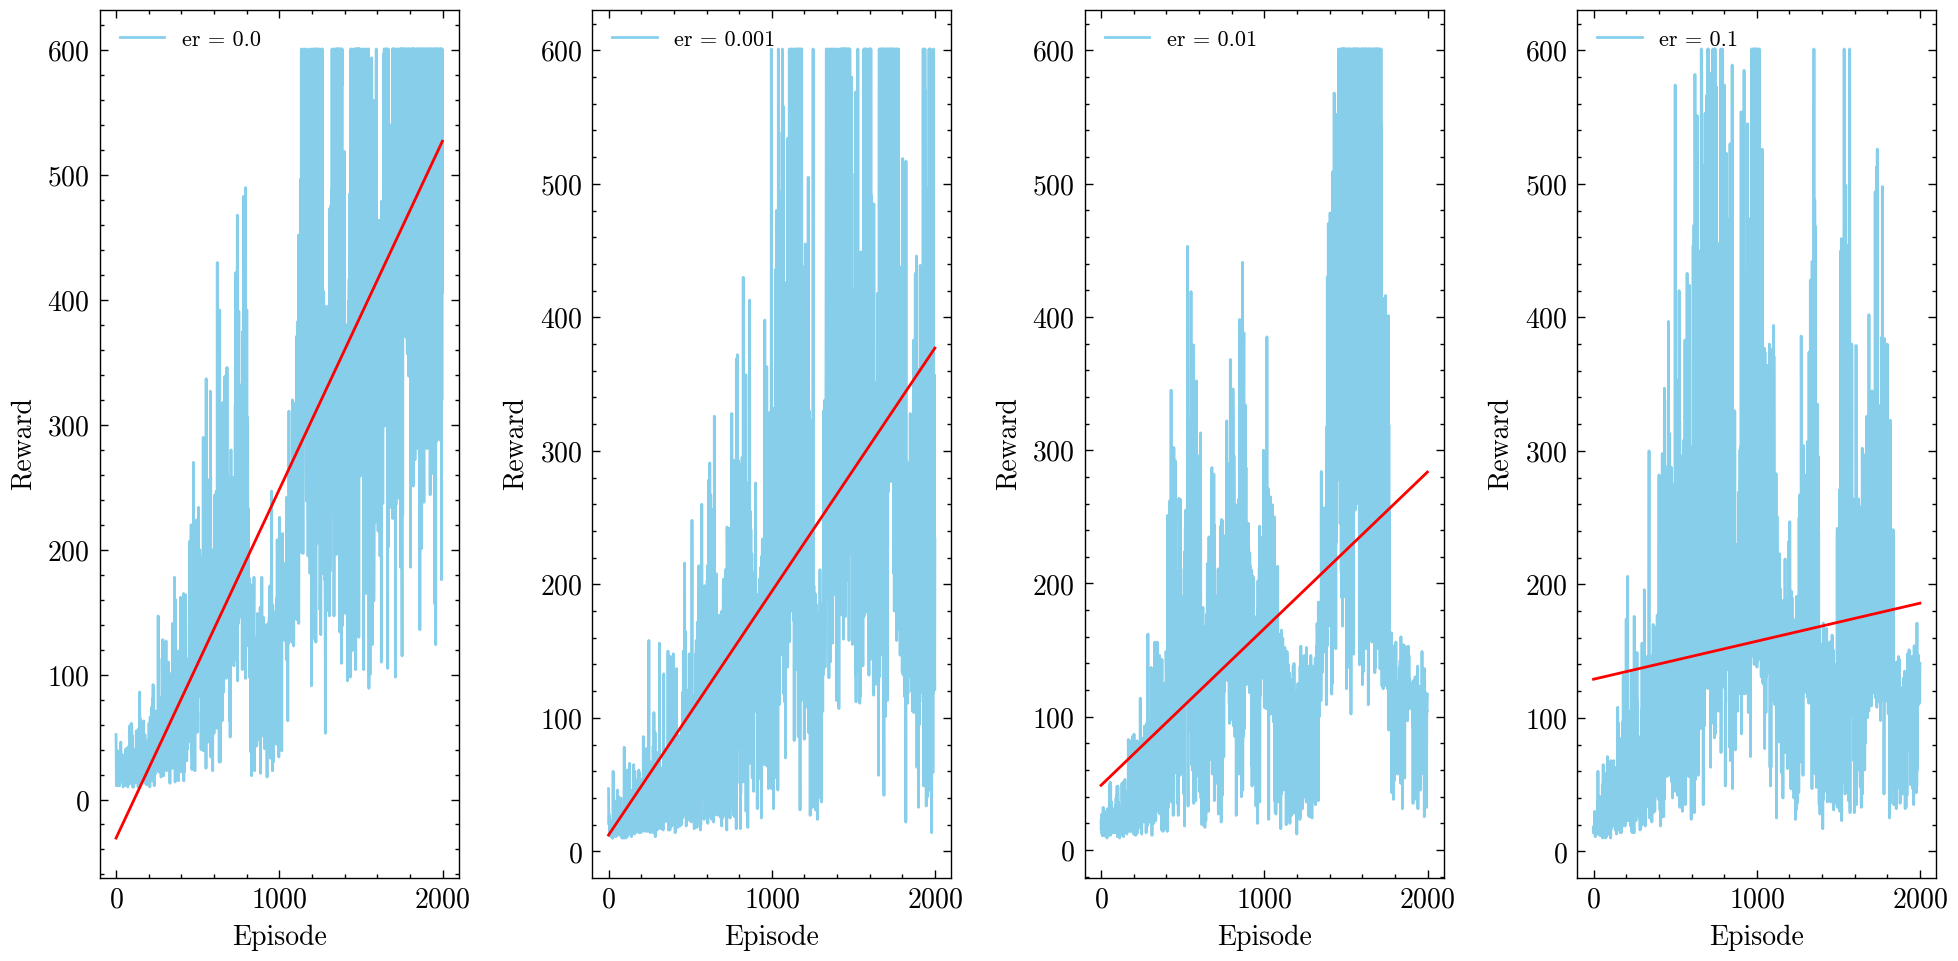

In [16]:
train_returns = [
    ('models/average_reward_new_entropy_0.0_episodes_reward.txt', 0.0, 'skyblue'),
    ('models/average_reward_new_entropy_0.001_episodes_reward.txt', 0.001, 'skyblue'),
    ('models/average_reward_new_entropy_0.01_episodes_reward.txt', 0.01, 'skyblue'),
    ('models/average_reward_new_entropy_0.1_episodes_reward.txt', 0.1, 'skyblue'),

    # ('models/ac_model_entropy_entropy_0.0_episodes_reward.txt', 0.0, 'plum'),
    # ('models/ac_model_entropy_entropy_0.001_episodes_reward.txt', 0.001, 'plum'),
    # ('models/ac_model_entropy_entropy_0.01_episodes_reward.txt', 0.01, 'plum'),
    # ('models/ac_model_entropy_entropy_0.1_episodes_reward.txt', 0.1, 'plum'),
    #
    # ('models/rloo_model_entropy_0.0_episodes_reward.txt', 0.0, 'sandybrown'),
    # ('models/rloo_model_entropy_0.001_episodes_reward.txt', 0.001, 'sandybrown'),
    # ('models/rloo_model_entropy_0.01_episodes_reward.txt', 0.01, 'sandybrown'),
    # ('models/rloo_model_entropy_0.1_episodes_reward.txt', 0.1, 'sandybrown'),
]
with plt.style.context(['science', 'no-latex']):

    fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=4)
    axs = axs.flatten()

    for ax, (returns, entropy, color) in zip(axs, train_returns):
        arr = np.loadtxt(returns)
        x = [i for i in range(len(arr))]

        ax.plot(arr, color=color, label=f'er = {entropy}')
        result = stats.linregress(x=x, y=arr)
        ax.plot(x, result.intercept + result.slope*np.float64(x), 'red')
        ax.legend(loc='upper left', prop={'size': 8})
        ax.set_xlabel('Episode')
        ax.set_ylabel('Reward')

    plt.tight_layout()
    plt.show()

`er` - величина коэффициента при энтропии в функции потерь

In [ ]:
with plt.style.context(['science', 'no-latex']):
    fig = plt.figure(figsize=(8, 5))
    tr = list(map(lambda x: np.loadtxt(x[0])[:500], train_returns))
     # Задаем позиции для каждого набора ящиков
    positions1 = np.arange(1, 5) - 0.2  # Сдвигаем первый набор влево
    positions2 = np.arange(1, 5)        # Второй набор остается по центру
    positions3 = np.arange(1, 5) + 0.2  # Сдвигаем третий набор вправо

    # Рисуем ящики с усами для каждого набора данных
    plt.boxplot(tr[:4], positions=positions1, showfliers=False, widths=0.1)
    plt.boxplot(tr[4:8], positions=positions2, showfliers=False, widths=0.1)
    plt.boxplot(tr[8:], positions=positions3, showfliers=False, widths=0.1)

    plt.xticks(ticks=np.arange(1, 5), labels=['0.0', '0.001', '0.01', '0.1'])

    plt.show()

In [2]:
val_returns = [
    ('models/average_reward_new_entropy_0.0_validation_rewards.txt', 0.0, 'skyblue'),
     ('models/average_reward_new_entropy_0.001_validation_rewards.txt', 0.001, 'plum'),
    ('models/average_reward_new_entropy_0.01_validation_rewards.txt', 0.01, 'sandybrown'),
    ('models/average_reward_new_entropy_0.1_validation_rewards.txt', 0.1, 'olive'),

    # ('models/ac_model_entropy_entropy_0.0_validation_rewards.txt', 0.0, 'skyblue'),
    # ('models/ac_model_entropy_entropy_0.001_validation_rewards.txt', 0.001, 'plum'),
    # ('models/ac_model_entropy_entropy_0.01_validation_rewards.txt', 0.01, 'sandybrown'),
    # ('models/ac_model_entropy_entropy_0.1_validation_rewards.txt', 0.1, 'olive'),
    #
    # ('models/rloo_model_entropy_0.0_validation_rewards.txt', 0.0, 'skyblue'),
    # ('models/rloo_model_entropy_0.001_validation_rewards.txt', 0.001, 'plum'),
    # ('models/rloo_model_entropy_0.01_validation_rewards.txt', 0.01, 'sandybrown'),
    # ('models/rloo_model_entropy_0.1_validation_rewards.txt', 0.1, 'olive'),
]

/Users/ilyamikheev/Desktop/projects/cart-pole/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/ilyamikheev/Desktop/projects/cart-pole/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


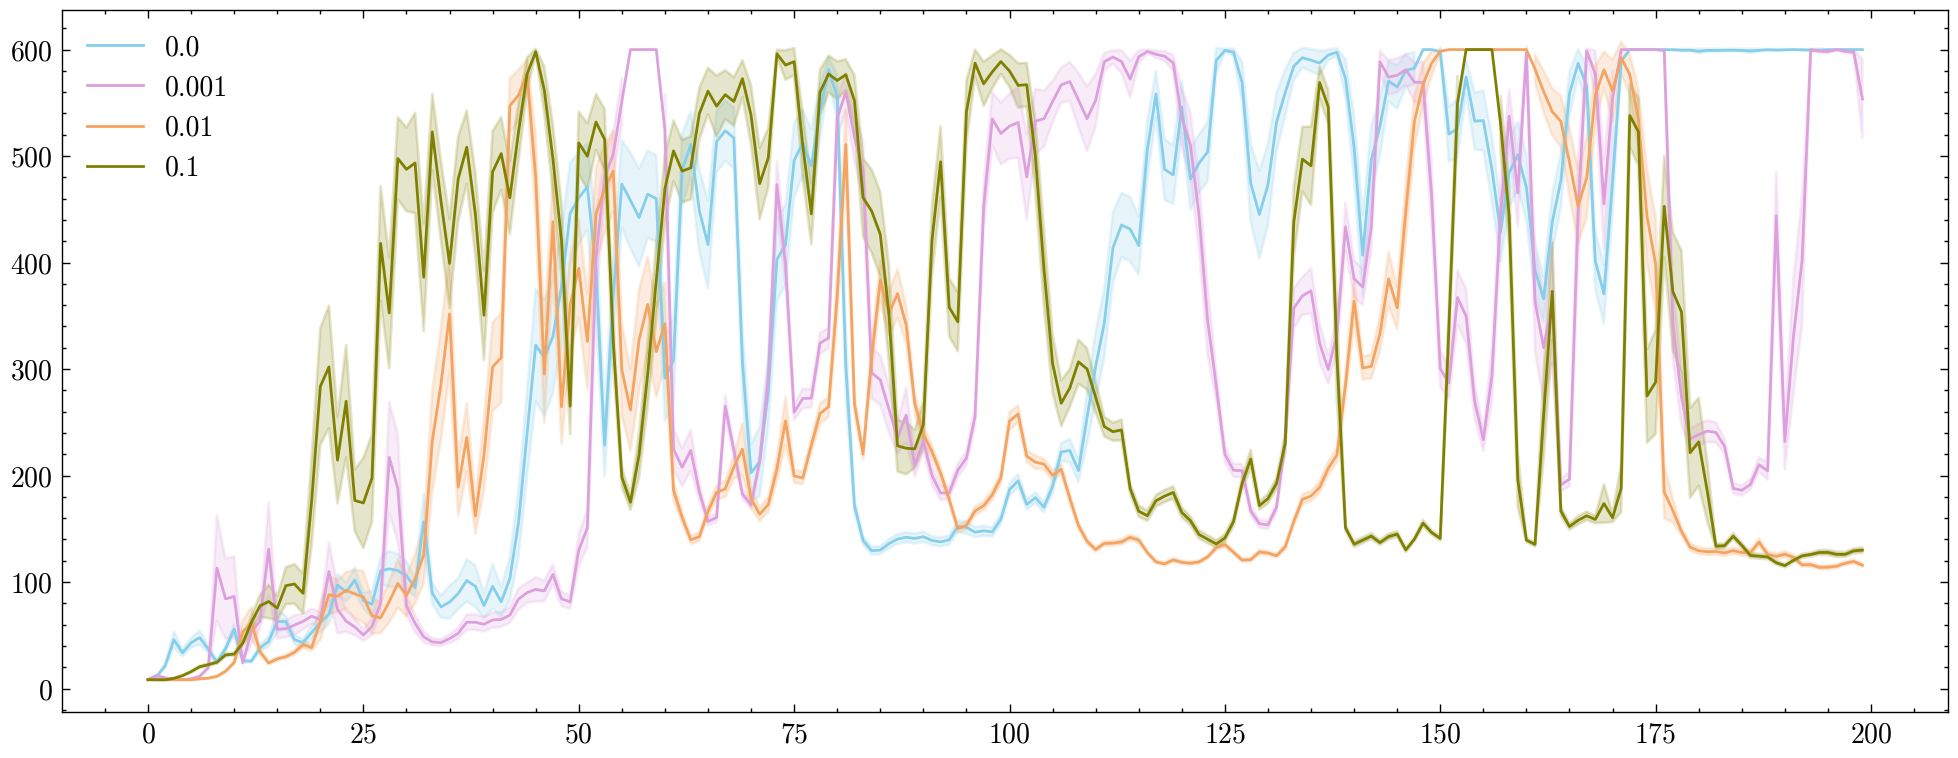

In [9]:
with plt.style.context(['science', 'no-latex']):

    def plot_with_confidence(arr: np.ndarray, confidence=0.95, color='b', label=''):
        means = np.mean(arr, axis=1)
        std_devs = np.std(arr, axis=1, ddof=1)
        sem = std_devs / np.sqrt(arr.shape[1])
        confidence_interval = stats.t.interval(confidence, df=arr.shape[1]-1, loc=means, scale=sem)
        plt.plot(range(len(means)), means, label=label, color=color)
        plt.fill_between(
            range(len(means)),
            confidence_interval[0],
            confidence_interval[1],
            color=color,
            alpha=0.2,
        )

    vr = list(map(lambda x: (np.loadtxt(x[0]), x[1], x[2]), val_returns))

    plt.figure(figsize=(10, 4))
    for validation_return, entropy, color in vr[0:4]:
        plot_with_confidence(validation_return, confidence=0.95, color=color, label=f'{entropy}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(8, 6))
    # for validation_return, entropy, color in vr[4:8]:
    #     plot_with_confidence(validation_return, confidence=0.95, color=color, label='Average reward entropy 0.0')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    #
    # plt.figure(figsize=(8, 6))
    # for validation_return, entropy, color in vr[8:]:
    #     plot_with_confidence(validation_return, confidence=0.95, color=color, label=f'entropy {entropy}')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()


In [ ]:


plt.figure(figsize=(10, 6))

plot_with_confidence(a, confidence=0.95, color='b', label='Average reward entropy 0.0')
plot_with_confidence(b, confidence=0.95, color='r', label='Average reward entropy 0.01')
plot_with_confidence(c, confidence=0.95, color='g', label='Average reward entropy 0.1')

plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.title('Средние значения с доверительным интервалом')
plt.legend()
plt.grid(True)
plt.show()

#### Behaviour cloning

Зафиксируем сиды

In [ ]:
n = 100
m = 100

bc_seeds = set([i for i in range(100_000, 200_000, 2)][:n]) # Для генерации траекторий
val_seeds = set([i + 1 for i in range(100_000, 200_000, 2)][:m]) # Для валидации ученика

In [73]:
test_policy = PolicyNetwork(state_dim=4, hidden_state_dim=64, action_space=2)
test_policy.load_state_dict(torch.load('models/ac_model_entropy_entropy_0.0_best.pth'))

<All keys matched successfully>

In [98]:
def evaluate_policy(environment: Env,
                    policy: nn.Module,
                    n_episodes=10,
                    seeds: List[int]=None,
                    truncate_episode_after_steps: int=600,
                    device="cpu"):

    if seeds is None:
        seeds = []
        for episode in range(n_episodes):
            seeds.append(random.randint(10_000, 100_000))

    episode_rewards = []

    episodes = [i for i in range(n_episodes)]
    for episode, seed in zip(episodes, seeds):

        state, _ = environment.reset(seed=seed)
        done = False
        total_reward = 0

        steps = 0
        while not done:

            action, log_prob, _ = select_action(state, policy, sample=False, device=device)
            state, reward, done, truncated, info = environment.step(action)
            total_reward += reward

            if steps >= truncate_episode_after_steps:
                break
            steps += 1

        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print(f"Evaluation over {n_episodes} episodes: Mean Reward = {mean_reward}, Std Reward = {std_reward}")
    return mean_reward, std_reward


def generate_trajectories(environment: Env,
                          policy: nn.Module,
                          episodes: int = None,
                          seeds: List[int] = None,
                          truncate_episode_after_steps: int=600,
                          device="cpu") -> (List[np.ndarray], List[int]):

    states: List[Tuple[float, float, float, float]] = []
    actions: List[int] = []

    if seeds is None:
        seeds = []
        for episode in range(episodes):
            seeds.append(random.randint(10_000, 100_000))

    for seed in seeds:
        state, _ = environment.reset(seed=seed)
        step = 0
        while True:

            action, _, _ = select_action(state, policy, sample=False, device=device)

            states.append(state)
            actions.append(action)

            state, _, terminate, truncated, _ = environment.step(action)

            if terminate:
                break
            if step >= truncate_episode_after_steps:
                break
            step += 1

    return states, actions


In [137]:
cart_pole_env = gymnasium.make('CartPole-v1')
states, actions = generate_trajectories(cart_pole_env, test_policy, seeds=set([random.randint(10_000, 1_000_000) for _ in range(1_000)]))

In [116]:
cart_position = np.array(states, dtype=np.float32)[:,0]
cart_velocity = np.array(states, dtype=np.float32)[:,1]
cart_angle = np.array(states, dtype=np.float32)[:,2]
cart_angular_velocity = np.array(states, dtype=np.float32)[:,3]

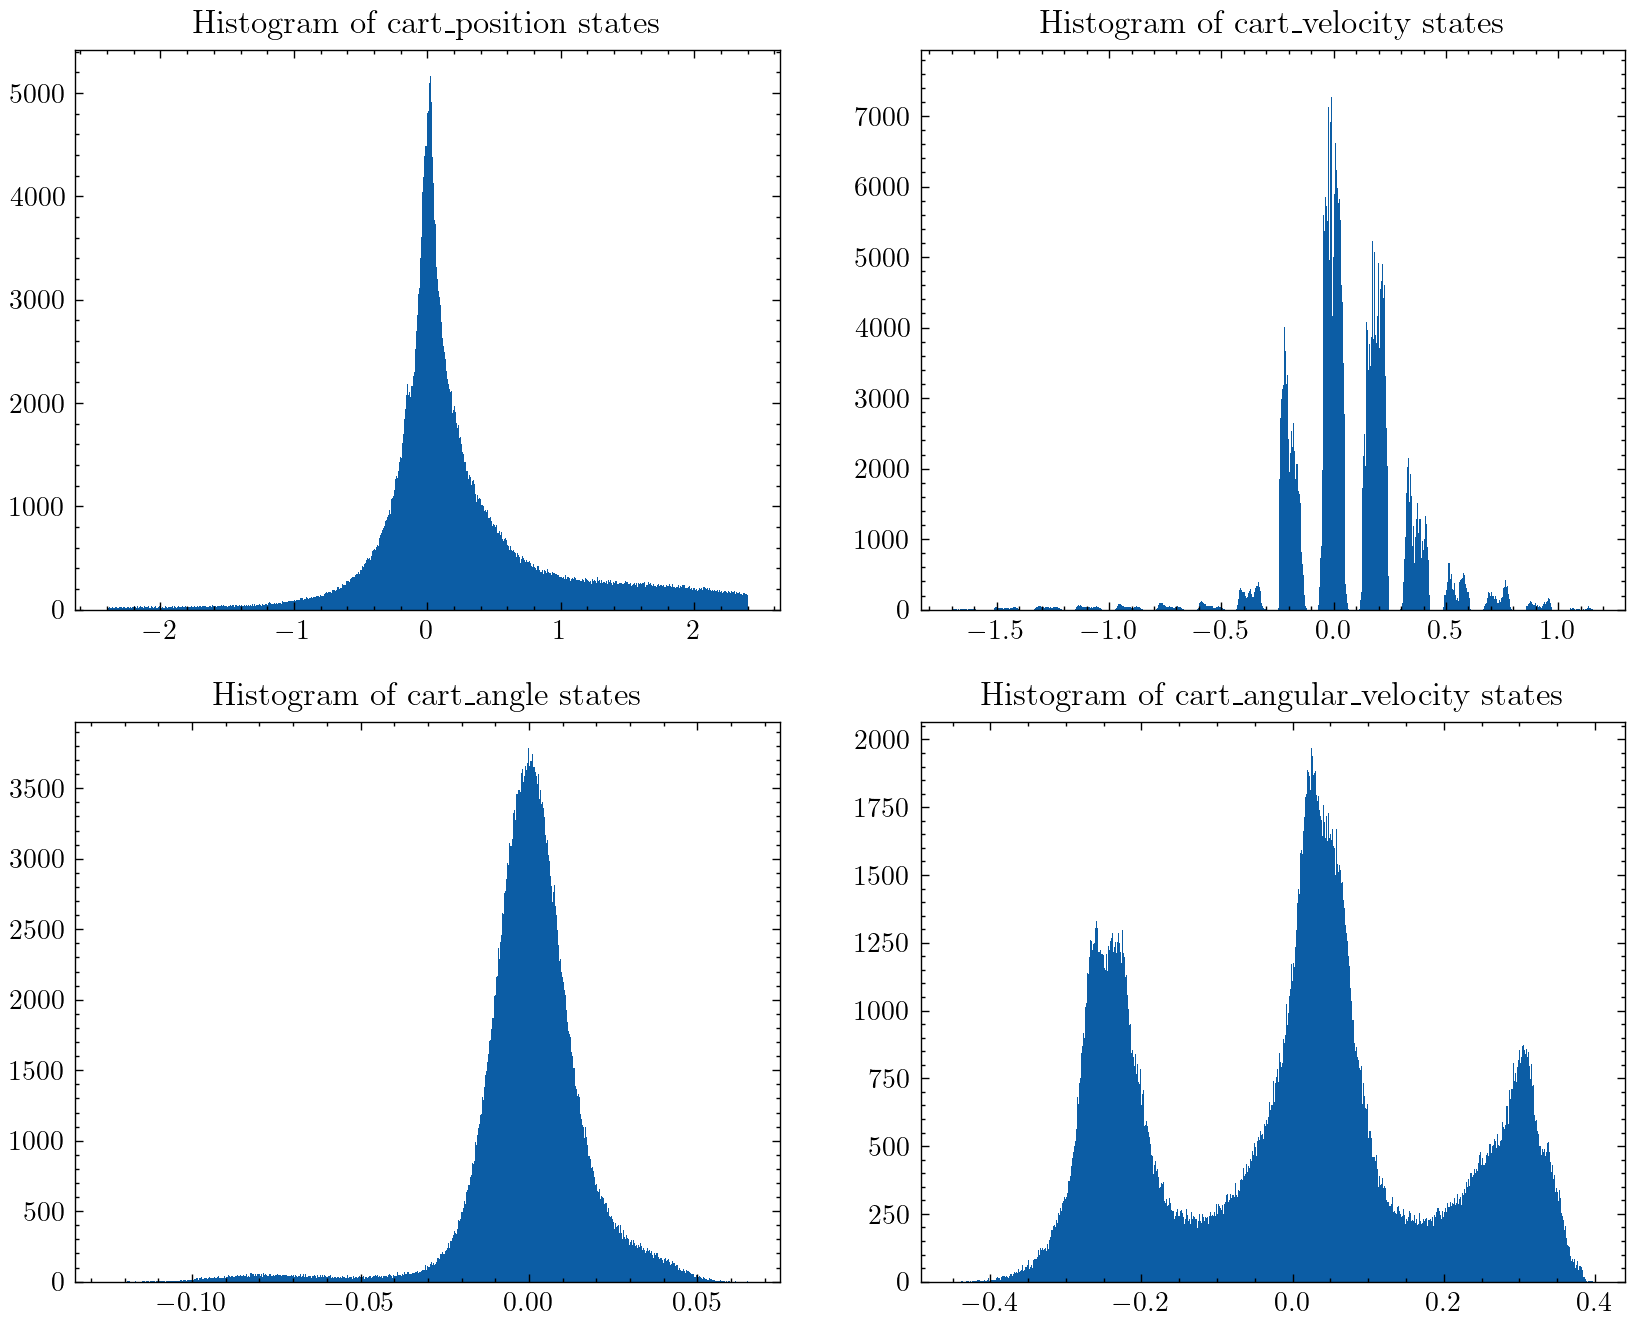

In [138]:
from matplotlib import pyplot as plt

states = np.array(states, dtype=np.float32)
fig, axs = plt.subplots(figsize=(10,8), nrows=2, ncols=2)
axs = axs.flatten()
titles = [
    "cart_position",
    "cart_velocity",
    "cart_angle",
    "cart_angular_velocity"
]

for i, ax in enumerate(axs):

    ax.hist(states[:, i], bins=1000)
    ax.set_title(f"Histogram of {titles[i]} states")


# plt.figure(figsize=(10, 4))
# plt.hist(cart_position, bins=100)
#
# plt.tight_layout()
# plt.title("Cart Position")
# plt.show()

In [100]:
class StateActionDataset(Dataset):
    def __init__(self, states: List[np.ndarray], actions: List[int]):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return {
            'states': torch.FloatTensor(self.states[idx]),
            'action': torch.FloatTensor([self.actions[idx]]),
        }

In [101]:
train_dataset = StateActionDataset(states, actions)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [102]:
bc_policy = PolicyNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bc_policy.parameters(), lr=0.001)

In [103]:
def train_bc(policy: PolicyNetwork,
             environment: Env,
             epochs: int,
             train_dataloader: DataLoader,
             criterion,
             optimizer: optim.Optimizer,
             eval_seeds: List[int],
             device):

    policy = policy.to(device)

    for epoch in range(epochs):

        policy.train()
        for b in train_dataloader:

            states = b['states'].to(device)
            _, logits = policy(states)

            gt_actions = b['action'].to(device)
            loss = criterion(logits, gt_actions.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        policy.eval()
        with torch.no_grad():
            mean_reward, std_reward = evaluate_policy(environment, policy, seeds=eval_seeds, device=device)
            print(mean_reward)
            print(std_reward)


train_bc(policy=bc_policy,
         train_dataloader=train_dataloader,
         epochs=50,
         environment=cart_pole_env,
         criterion=criterion,
         optimizer=optimizer,
         eval_seeds=[1, 2, 3, 4],
         device="mps")


Episode 1: Total Reward = 62.0
Episode 2: Total Reward = 66.0
Episode 3: Total Reward = 84.0
Episode 4: Total Reward = 90.0
Evaluation over 10 episodes: Mean Reward = 75.5, Std Reward = 11.779218989389747
75.5
11.779218989389747
Episode 1: Total Reward = 89.0
Episode 2: Total Reward = 77.0
Episode 3: Total Reward = 107.0
Episode 4: Total Reward = 62.0
Evaluation over 10 episodes: Mean Reward = 83.75, Std Reward = 16.48294573187693
83.75
16.48294573187693
Episode 1: Total Reward = 113.0
Episode 2: Total Reward = 111.0
Episode 3: Total Reward = 108.0
Episode 4: Total Reward = 71.0
Evaluation over 10 episodes: Mean Reward = 100.75, Std Reward = 17.268106439329124
100.75
17.268106439329124
Episode 1: Total Reward = 134.0
Episode 2: Total Reward = 119.0
Episode 3: Total Reward = 116.0
Episode 4: Total Reward = 80.0
Evaluation over 10 episodes: Mean Reward = 112.25, Std Reward = 19.828956099603428
112.25
19.828956099603428
Episode 1: Total Reward = 143.0
Episode 2: Total Reward = 359.0
Episo

KeyboardInterrupt: 

In [132]:
arr = []

for i in range(5):
    arr1 = []
    obs, _ = cart_pole_env.reset(seed=100)
    for i in range(10):
        print(obs)
        arr1.append(obs)
        action = cart_pole_env.action_space.sample()
        obs, _, _, _, _ = cart_pole_env.step(action)
    arr.append(arr1)

[ 0.03349816  0.0096554  -0.02111368 -0.04570484]
[ 0.03369127 -0.18515752 -0.02202777  0.24024247]
[ 0.02998812  0.01027205 -0.01722292 -0.05930644]
[ 0.03019356 -0.18459877 -0.01840905  0.22789316]
[ 0.02650159  0.01078135 -0.01385119 -0.07053933]
[ 0.02671721  0.20609912 -0.01526198 -0.36755997]
[ 0.0308392   0.40143457 -0.02261318 -0.6650159 ]
[ 0.03886789  0.5968636  -0.03591349 -0.9647323 ]
[ 0.05080516  0.7924492  -0.05520814 -1.2684777 ]
[ 0.06665415  0.5980741  -0.08057769 -0.9935821 ]
[ 0.03349816  0.0096554  -0.02111368 -0.04570484]
[ 0.03369127  0.20507365 -0.02202777 -0.34497383]
[ 0.03779274  0.01027186 -0.02892725 -0.05931769]
[ 0.03799818 -0.18442364 -0.0301136   0.22409996]
[ 0.03430971  0.01111548 -0.0256316  -0.0779278 ]
[ 0.03453202  0.20659532 -0.02719016 -0.3785861 ]
[ 0.03866392  0.40209264 -0.03476188 -0.67971665]
[ 0.04670578  0.5976798  -0.04835622 -0.983138  ]
[ 0.05865937  0.7934151  -0.06801897 -1.290609  ]
[ 0.07452767  0.5992208  -0.09383115 -1.0199733 ]


In [133]:
arr

[[array([ 0.03349816,  0.0096554 , -0.02111368, -0.04570484], dtype=float32),
  array([ 0.03369127, -0.18515752, -0.02202777,  0.24024247], dtype=float32),
  array([ 0.02998812,  0.01027205, -0.01722292, -0.05930644], dtype=float32),
  array([ 0.03019356, -0.18459877, -0.01840905,  0.22789316], dtype=float32),
  array([ 0.02650159,  0.01078135, -0.01385119, -0.07053933], dtype=float32),
  array([ 0.02671721,  0.20609912, -0.01526198, -0.36755997], dtype=float32),
  array([ 0.0308392 ,  0.40143457, -0.02261318, -0.6650159 ], dtype=float32),
  array([ 0.03886789,  0.5968636 , -0.03591349, -0.9647323 ], dtype=float32),
  array([ 0.05080516,  0.7924492 , -0.05520814, -1.2684777 ], dtype=float32),
  array([ 0.06665415,  0.5980741 , -0.08057769, -0.9935821 ], dtype=float32)],
 [array([ 0.03349816,  0.0096554 , -0.02111368, -0.04570484], dtype=float32),
  array([ 0.03369127,  0.20507365, -0.02202777, -0.34497383], dtype=float32),
  array([ 0.03779274,  0.01027186, -0.02892725, -0.05931769], d